In [327]:
#import all needed libraries
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline


# FBI Gun Data Analysis

## Table of Content:
<ul>
    <li><a href = '#introduction'>Introduction</a></li>
    <li><a href = '#Data Wrangling'>Data Wrangling</a></li>
    <li><a href = '#Population for different states (Census 2010)'>Population for different states (Census 2010)</a></li>
    <li><a href = '#Total Background Check Initiated at Different States (Year 2016)'>Total Background Check Initiated at Different States (Year 2016)</a></li>
    <li><a href = '#Gun permits per person at different states'>Gun permits per person at different states</a></li>
    <li><a href = '#Change of Total Background Checks for Firearm Purchase for United States from 1999 - 2016 ( All States )'>Change of Total Background Checks for Firearm Purchase for United States from 1999 - 2016 ( All States )</a></li>
    <li><a href = '#Change of Total Background Checks for Firearm Purchase in individual states from 1999 - 2016'>Change of Total Background Checks for Firearm Purchase in individual states from 1999 - 2016</a></li>
    <li><a href = '#Total Casualties of Gun Violence in 2016'>Total Casualties of Gun Violence in 2016</a></li>
    <li><a href = '#Total Casualties of Gun Violence in 2016 per Population'>Total Casualties of Gun Violence in 2016 per Population</a></li>
    <li><a href = '#Complete Comparison for Census Data Criteria and Per Capita Casualties of Gun Violence'>Complete Comparison for Census Data Criteria and Per Capita Casualties of Gun Violence</a></li>
<ul>

<a id='introduction'></a>
## Introduction

This is a project based on the data from the FBI's National Instant Criminal Background Check System and the State level data from Census.gov.The orignal data can be found with files named 'NICS_Firearm_Checks.csv' and 'us_census data.csv' in the same repository. 



<a id = 'Data Wrangling'></a>
## Data Wrangling

In [379]:
#show orginal data of 'us_census data.csv':
us_census_data = pd.read_csv('us_census data.csv')

In [380]:
#Drop the Fact Note column since it contains no useful information for analysis
us_census_data = us_census_data.drop(['Fact Note'], axis = 1)
#drop all the footnote and keep only the useful data with numbers values
us_census_data = us_census_data[:64] 
#Replace all Z,D and FN with 0 based on the footnote definition
us_census_data = us_census_data.replace({'Z':'0','D':'0','FN':'0'}) 
#Remove all ',', '%' and '$' in the dataframe
us_census_data.loc[:,'Alabama':'Wyoming'] = us_census_data.loc[:,'Alabama':'Wyoming'].replace({',':'','%':'',r'\$':''},regex = True)
#Cast the each column's value to float data type
us_census_data.loc[:,'Alabama':'Wyoming'] = us_census_data.loc[:,'Alabama':'Wyoming'].astype(float)


In [381]:
#read the original gun_data.csv 
fbi_gun_data = pd.read_csv('NICS_Firearm_Checks.csv') 

In [382]:
#fill NaN in the dataframe with 0
fbi_gun_data = fbi_gun_data.fillna(0) 
#Cast all values to float data type
fbi_gun_data.loc[:,'permit':'totals'] = fbi_gun_data.loc[:,'permit':'totals'].astype(float, inplace = True)
# convert the month column to datetime format
fbi_gun_data['month'] = pd.to_datetime(fbi_gun_data['month'])

Let's take a quick look at both cleaned datasets.

In [383]:
us_census_data.head(3)

Fact      Alabama  Alaska  \
0       Population estimates, July 1, 2016,  (V2016)   4.8633e+06  741894   
1  Population estimates base, April 1, 2010,  (V2...  4.78013e+06  710249   
2  Population, percent change - April 1, 2010 (es...          1.7     4.5   

       Arizona     Arkansas   California     Colorado  Connecticut Delaware  \
0  6.93107e+06  2.98825e+06    3.925e+07  5.54054e+06  3.57645e+06   952065   
1   6.3923e+06  2.91602e+06  3.72545e+07  5.02932e+06  3.57411e+06   897936   
2          8.4          2.5          5.4         10.2          0.1        6   

       Florida  ... South Dakota    Tennessee        Texas         Utah  \
0  2.06124e+07  ...       865454  6.65119e+06  2.78626e+07  3.05122e+06   
1  1.88046e+07  ...       814195   6.3463e+06  2.51461e+07  2.76389e+06   
2          9.6  ...        0.063        0.048         10.8         10.4   

  Vermont     Virginia   Washington West Virginia    Wisconsin Wyoming  
0  624594  8.41181e+06    7.288e+06    1.8311e+06  5.77871e+06  585501  
1  625741  8.00104e+06  6.72454e+06   1.85301e+06  5.68729e+06  563767  
2    -0.2          5.1          8.4          -1.2          1.6     3.9  

[3 rows x 51 columns]

In [384]:
fbi_gun_data.head(3)

month    state   permit  permit_recheck  handgun  long_gun  other  \
0 2017-09-01  Alabama  16717.0             0.0   5734.0    6320.0  221.0   
1 2017-09-01   Alaska    209.0             2.0   2320.0    2930.0  219.0   
2 2017-09-01  Arizona   5069.0           382.0  11063.0    7946.0  920.0   

   multiple  admin  prepawn_handgun  ...  returned_other  rentals_handgun  \
0     317.0    0.0             15.0  ...             0.0              0.0   
1     160.0    0.0              5.0  ...             0.0              0.0   
2     631.0    0.0             13.0  ...             0.0              0.0   

   rentals_long_gun  private_sale_handgun  private_sale_long_gun  \
0               0.0                   9.0                   16.0   
1               0.0                  17.0                   24.0   
2               0.0                  38.0                   12.0   

   private_sale_other  return_to_seller_handgun  return_to_seller_long_gun  \
0                 3.0                       0.0                        0.0   
1                 1.0                       0.0                        0.0   
2                 2.0                       0.0                        0.0   

   return_to_seller_other   totals  
0                     3.0  32019.0  
1                     0.0   6303.0  
2                     0.0  28394.0  

[3 rows x 27 columns]

In [385]:
# This data is pulled from https://www.gunviolencearchive.org/reports/mass-shooting?page=2&year=2016
gun_violence_2016 = pd.read_csv('gun_violence_2016.csv')
gun_violence_2016 = gun_violence_2016.drop('Operations', axis = 1).fillna(-1)
gun_violence_2016['Incident Date'] = pd.to_datetime(gun_violence_2016['Incident Date'])
gun_violence_2016 = gun_violence_2016.rename(columns = {"# Killed": "Killed", "# Injured": "Injured"})
gun_violence_2016['Total Casualty'] = gun_violence_2016['Killed'] + gun_violence_2016['Injured']


In [386]:
gun_violence_2016.head()

Incident Date        State     City Or County             Address  Killed  \
0    2016-12-31      Georgia  Lenox (El Dorado)     27 Briarwood Ct       2   
1    2016-12-31        Texas            Houston  3704 Fannin Street       1   
2    2016-12-30         Ohio          Mansfield  3230 Possum Run Rd       0   
3    2016-12-30  Connecticut        Wallingford    95 S Turnpike Rd       2   
4    2016-12-28      Georgia           Columbus    2914 10th Street       1   

   Injured  Total Casualty  
0        2               4  
1        3               4  
2        5               5  
3        3               5  
4        4               5

<a id = 'Population for different states (Census 2010)'></a>
## Population for different states (Census 2010)
In this section we will investigate population at different individual states at year 2010 when the most recent census was done

In [387]:
#Loading the US map shapefile
map_path = "./us_states/tl_2017_us_state.shp"
usa = gpd.read_file(map_path)
#Drop non-state data
usa = usa.set_index('NAME').drop(['Guam','United States Virgin Islands','Commonwealth of the Northern Mariana Islands','American Samoa','District of Columbia','Puerto Rico'])

all_states_population = us_census_data.iloc[3]['Alabama':'Wyoming']
all_states_population = all_states_population.reset_index().rename(columns = {'index':'NAME',3:'Population'}).set_index('NAME')
usa = pd.concat([usa,all_states_population], axis = 1, sort = True)


Text(0.5, 1.0, 'Population in Each of the 48 Contiguous States. Data from 2010 Census')

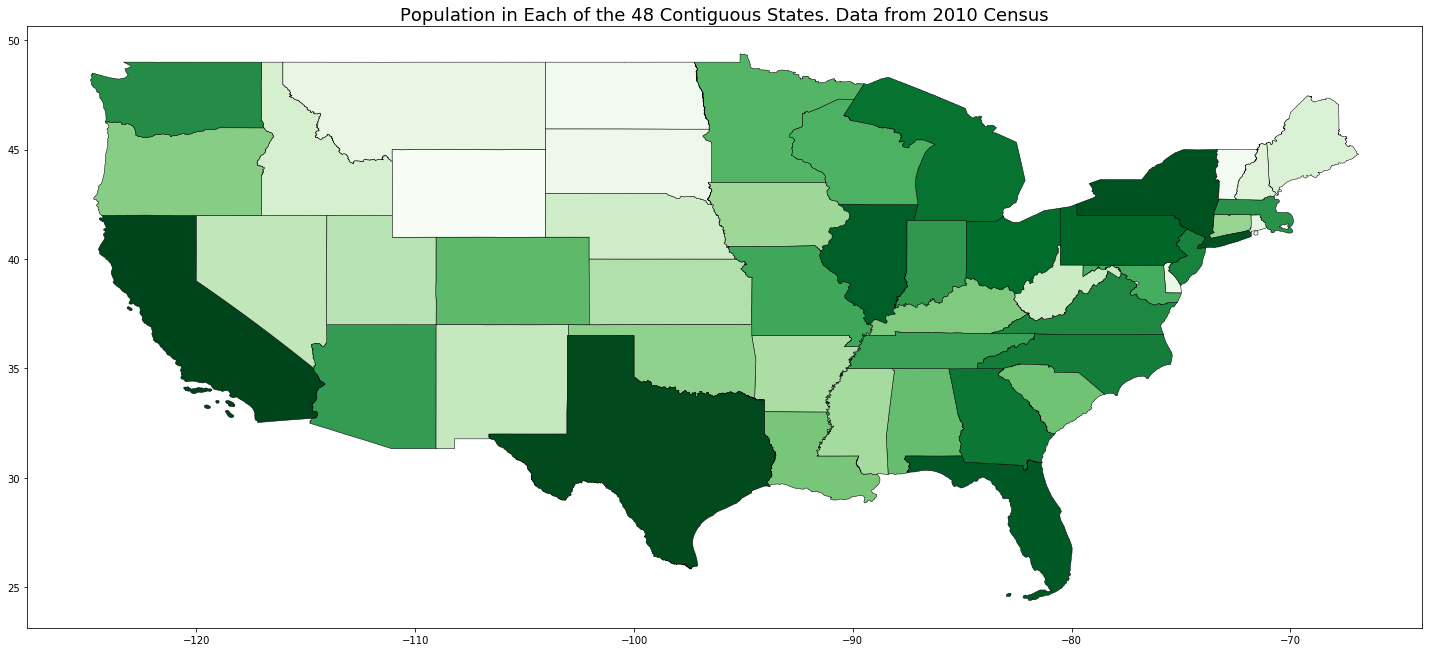

In [388]:
usa.drop(['Hawaii','Alaska']).plot(column = 'Population', cmap = 'Greens', figsize = (25,15), linewidth = 0.5, edgecolor = 'k')
plt.title("Population in Each of the 48 Contiguous States. Data from 2010 Census", fontsize = 18)


Text(0.5, 1.0, 'Population in Each of the 48 Contiguous States. Data from 2010 Census')

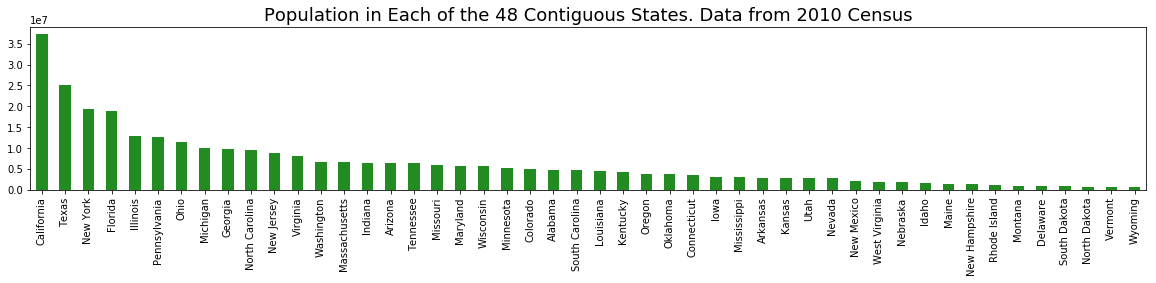

In [389]:
usa.drop(['Hawaii','Alaska'])['Population'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,3), color = 'forestgreen')
plt.title("Population in Each of the 48 Contiguous States. Data from 2010 Census", fontsize = 18)

<a id = 'Total Background Check Initiated at Different States (Year 2016)'></a>
## Total Background Check Initiated at Different States (Year 2016)
In this section we will investigate total gun registration in different states at year 2016. 
Federal law requires criminal background checks for all firearm sales by licensed gun dealers to ensure that dealers do not sell guns to felons, domestic abusers, and other people prohibited from having them. However, federal law does not require background checks or any other process for firearms sold by unlicensed sellers. Nontheless, the value of the background check initiated is still a good indicator of level of the total gun sales. 

In [390]:
#create a new column stores the information of year for each row
fbi_gun_data['year'] = fbi_gun_data['month'].dt.year
#select rows with year 2016 and group the data by states and calculae the sum of totals for the year
# also, drop all the non-state data
backgroundCheck_y2016 = fbi_gun_data.loc[fbi_gun_data['year'] == 2016].groupby('state')['totals'].sum().drop(index = ['District of Columbia','Guam','Mariana Islands','Puerto Rico','Virgin Islands'])
backgroundCheck_y2016 = backgroundCheck_y2016.reset_index().rename(columns = {'state':'NAME','totals':'Total Background Checks Initiated'}).set_index('NAME')
usa = pd.concat([usa,backgroundCheck_y2016], axis = 1, sort = True)

Text(0.5, 1.0, 'Total Number of Background Checks Initiated for Firearm Purchase in 2016 - U.S. Area Map View')

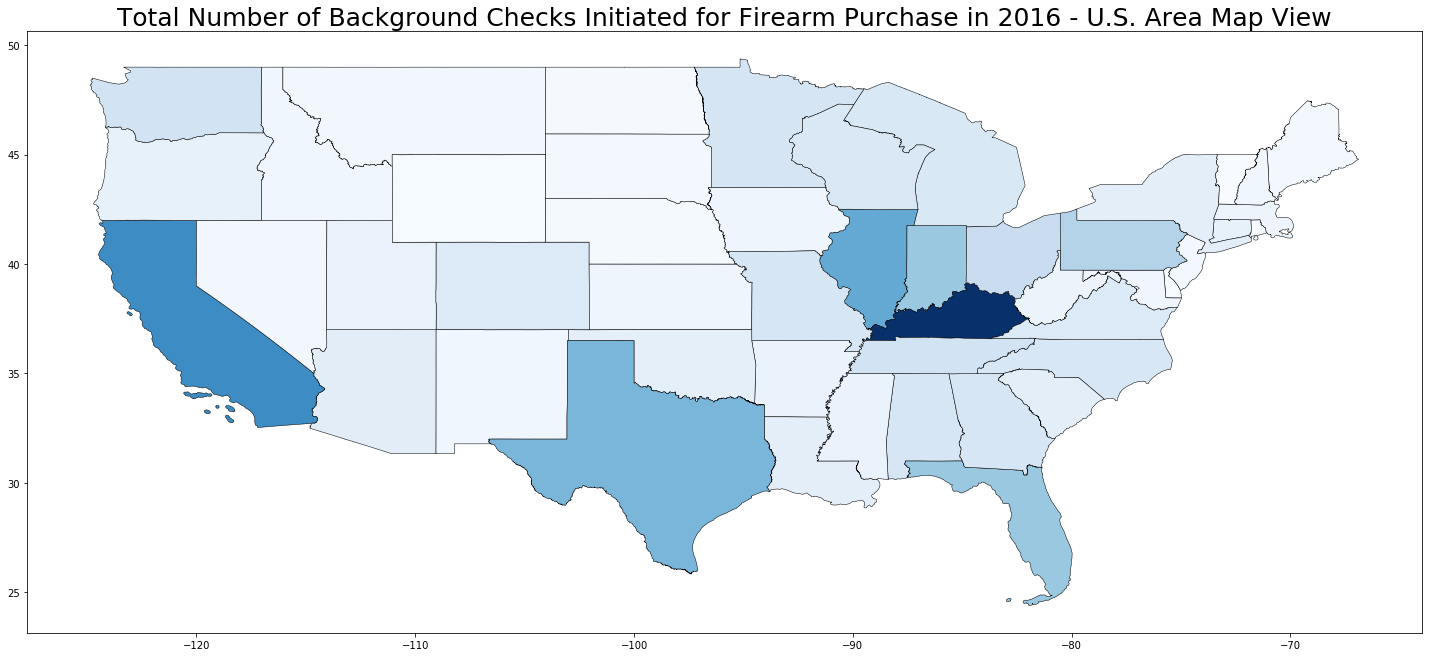

In [391]:
usa.drop(['Hawaii','Alaska']).plot(column = 'Total Background Checks Initiated', cmap = 'Blues', figsize = (25,25), linewidth = 0.5, edgecolor = 'k')
plt.title("Total Number of Background Checks Initiated for Firearm Purchase in 2016 - U.S. Area Map View", fontsize = 25)



Text(0.5, 1.0, 'Total Number of Background Checks Initiated for Firearm Purchase in 2016')

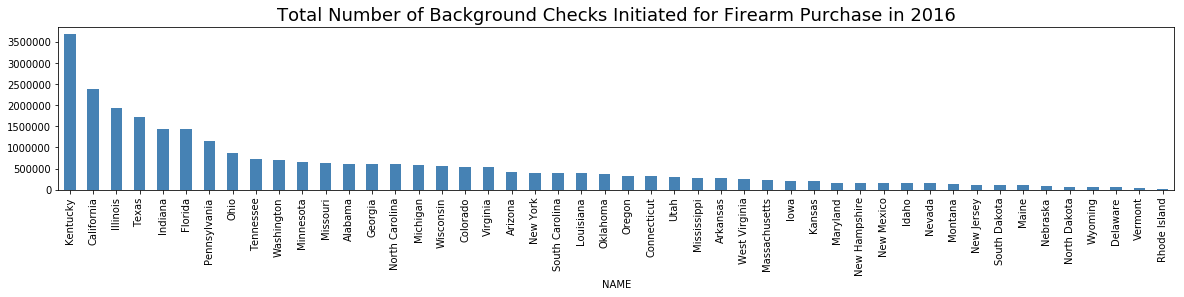

In [392]:
usa.drop(['Hawaii','Alaska'])['Total Background Checks Initiated'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,3), color = 'steelblue')
plt.title("Total Number of Background Checks Initiated for Firearm Purchase in 2016", fontsize = 18)

Major findings: Kentucky has the highest number of initated background check for firearm purchase in all states in 2016.

<a id = 'Gun permits per person at different states'></a>
## Normailzed Background Check Initiation per Person in different states
In this section we will investigate the normalized background check per capita for different states at yeat 2016

In [393]:
usa['Gun Permits per person'] = (usa['Total Background Checks Initiated']/usa['Population'])*1000

Text(0.5, 1.0, 'Total Number of Background Checks Initiated for Firearm Purchase per 1000 population in 2016, U.S. Map View')

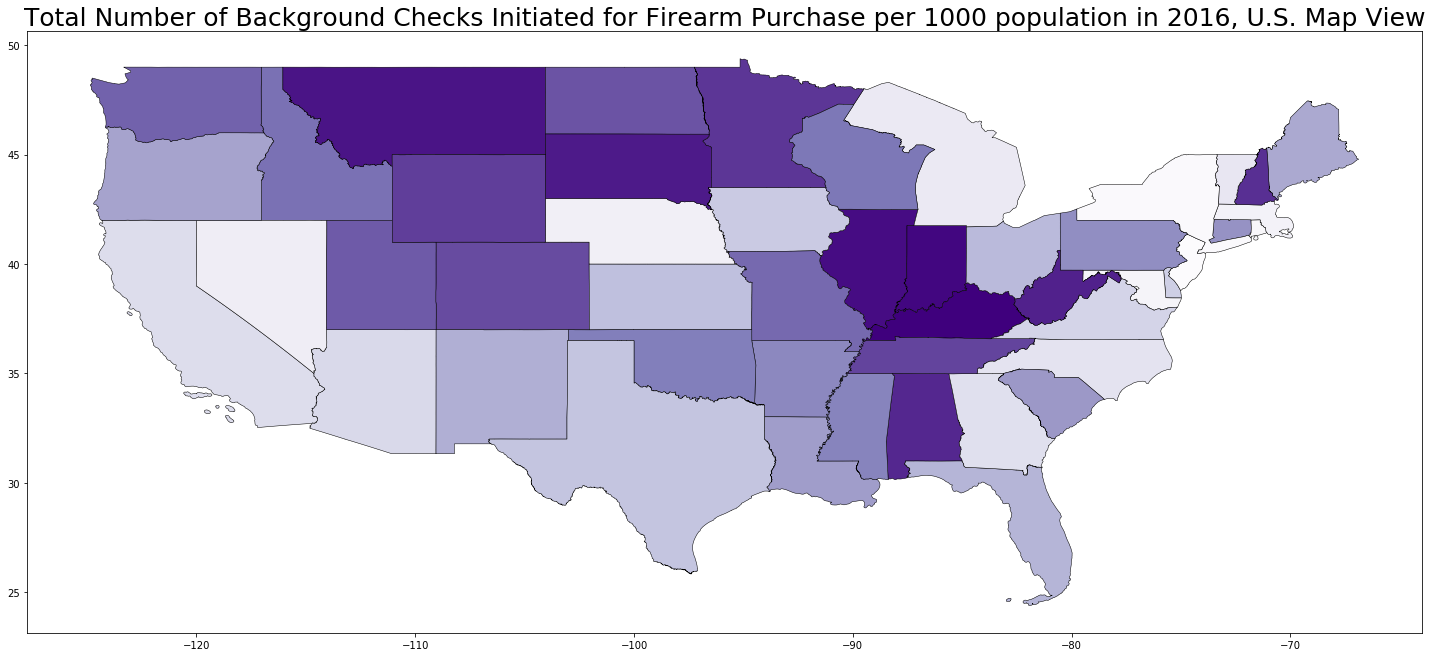

In [394]:
usa.drop(['Hawaii','Alaska']).plot(column = 'Gun Permits per person', cmap = 'Purples', figsize = (25,25), linewidth = 0.5, edgecolor = 'k')
plt.title("Total Number of Background Checks Initiated for Firearm Purchase per 1000 population in 2016, U.S. Map View", fontsize = 25)

Text(0.5, 1.0, 'Total Number of Background Checks Initiated for Firearm Purchase per 1000 population in 2016')

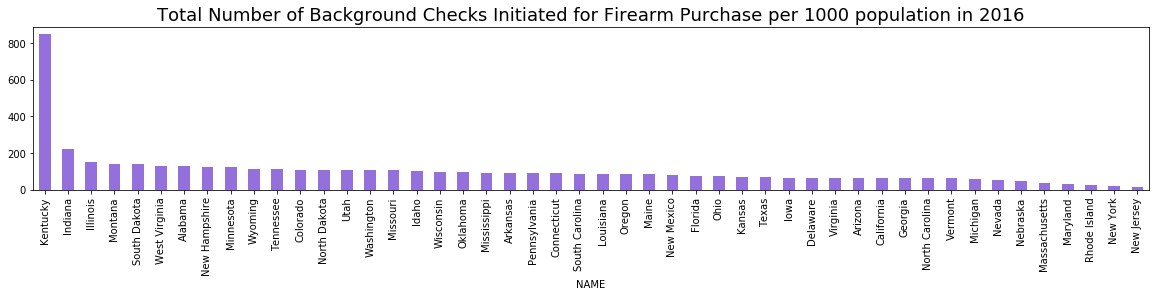

In [395]:
usa.drop(['Hawaii','Alaska'])['Gun Permits per person'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,3), color = 'mediumpurple')
plt.title("Total Number of Background Checks Initiated for Firearm Purchase per 1000 population in 2016", fontsize = 18)


Major findings: Kentucky has the highest per capita gun background check initiation in all states in 2016

<a id = 'Change of Total Background Checks for Firearm Purchase for United States from 1999 - 2016 ( All States )'></a>
## Change of Total Background Checks for Firearm Purchase for United States from 1999 - 2016 ( All States )
In this section we will look at the growth of total backgrund check initiation from 1999 to 2016 at national level

In [396]:
# Calculate the national total for different years pick only the data from 1999 to 2016\
# since they contain all months
permits_1999_to_2016 = fbi_gun_data.groupby(['year']).sum().iloc[1:-1]  
permits_1999_to_2016['total_million'] = (permits_1999_to_2016['totals']/1000000)

Text(0.5, 1.0, 'Change of National Total Background Checks for Firearm Purchase for United States from 1999 - 2016 (All States)')

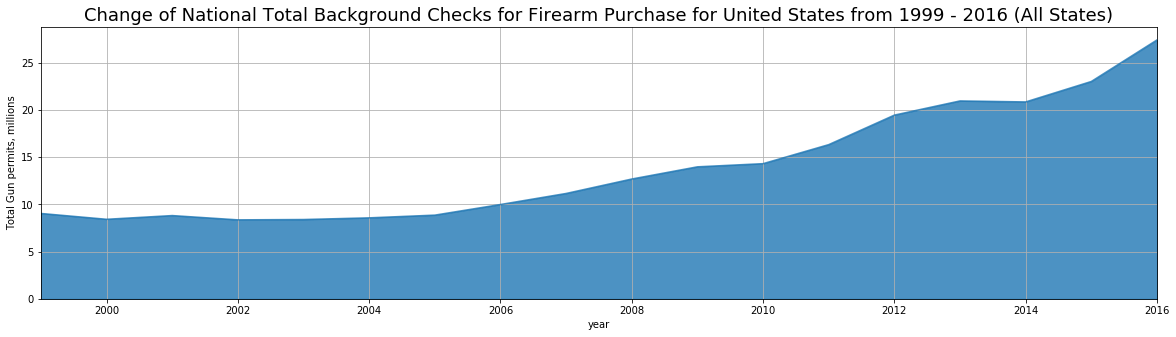

In [397]:
#plot the final result
permits_1999_to_2016['total_million'].plot(kind = 'area',figsize = (20,5),grid = True,alpha = 0.8).set(ylabel = 'Total Gun permits, millions')
plt.title('Change of National Total Background Checks for Firearm Purchase for United States from 1999 - 2016 (All States)', fontsize = 18)


Major findings: The total background check initiation is increasing steadily from 1999 to 2016, potentially inidcates an incraeaing of total gun sales. 

<a id = 'Change of Total Background Checks for Firearm Purchase in individual states from 1999 - 2016'></a>
## Change of Total Background Checks for Firearm Purchase in individual states from 1999 - 2016
In this section we will look at the growth of total gun registraion at state level from 1999 to 2016

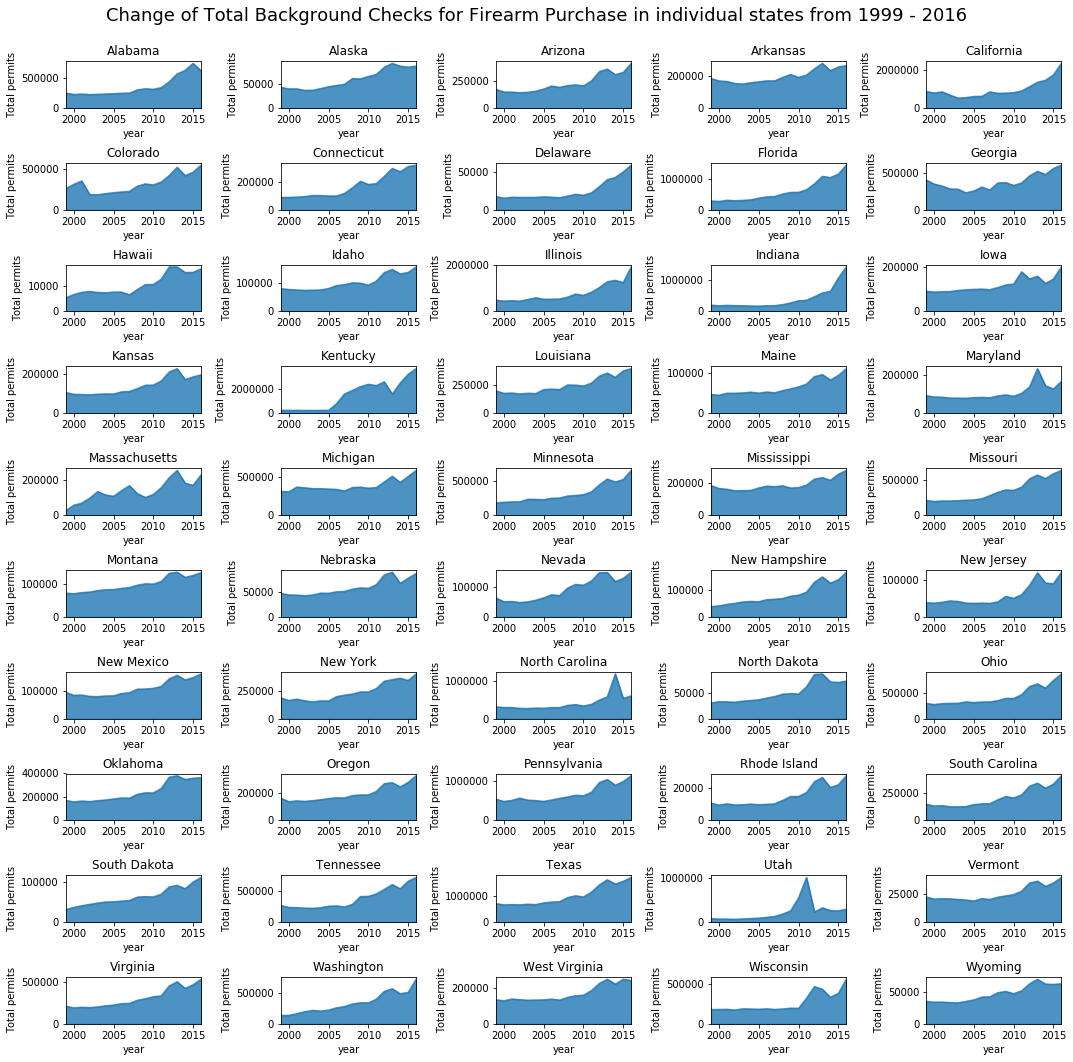

In [398]:
#create a figure with 50 empty subplot spots
fig, axes = plt.subplots(nrows=10, ncols=5) 
i = 0
k = 0

for state in us_census_data.drop(['Fact'], axis = 1).columns.tolist():
    if k <= 4:
        # Group the modified df2 with selected state by 'year' calculate the yearly sum. Then,\
        #drop the data for 1988 and 2017 because they don't include the whole year
        state_permit_1999_2016 = fbi_gun_data.groupby(['state']).get_group(state).groupby(['year']).sum()[1:-1]
        
        #plot a subplot of a selected state 
        state_permit_1999_2016['totals'].plot(ax=axes[i,k],figsize = (15,15),title = state, kind = 'area',grid = False,alpha = 0.8).set(ylabel = 'Total permits')
        #move to next column positon on the same row
        k = k + 1 
    elif k > 4:
        # move the column to position 0
        k = 0
        # move the to next row
        i = i + 1
        # Group the modified df2 with selected state by 'year' calculate the yearly sum. Then,\
        #drop the data for 1988 and 2017 because they don't include the whole year
        state_permit_1999_2016 = fbi_gun_data.groupby(['state']).get_group(state).groupby(['year']).sum()[1:-1]
        #plot a subplot of a selected state 
        state_permit_1999_2016['totals'].plot(ax=axes[i,k],figsize = (20,20),title = state, kind = 'area',grid = False,alpha = 0.8).set(ylabel = 'Total permits')
        #move to next column positon on the same row
        k = k + 1
        
plt.tight_layout()
fig.suptitle('Change of Total Background Checks for Firearm Purchase in individual states from 1999 - 2016',fontsize = 18)
fig.subplots_adjust(top=0.93)

It looks the general trend for the number background check initiation is upward for every single state.|

<a id = 'Total Casualties of Gun Violence in 2016'></a>
## Total Casualties of Gun Violence in 2016

In [400]:
gun_violence_2016.head()

Incident Date        State     City Or County             Address  Killed  \
0    2016-12-31      Georgia  Lenox (El Dorado)     27 Briarwood Ct       2   
1    2016-12-31        Texas            Houston  3704 Fannin Street       1   
2    2016-12-30         Ohio          Mansfield  3230 Possum Run Rd       0   
3    2016-12-30  Connecticut        Wallingford    95 S Turnpike Rd       2   
4    2016-12-28      Georgia           Columbus    2914 10th Street       1   

   Injured  Total Casualty  
0        2               4  
1        3               4  
2        5               5  
3        3               5  
4        4               5

In [401]:
casualty_2016 = gun_violence_2016.groupby('State').sum()['Total Casualty']
casualty_2016 = casualty_2016.reset_index().rename(columns = {'State':'NAME'}).set_index('NAME')
usa = pd.concat([usa,casualty_2016], axis = 1, sort = True).fillna(0)

Text(0.5, 1.0, 'Casualties of Gun Violence of the 48 Contiguous States. 2016, U.S. Area Map View')

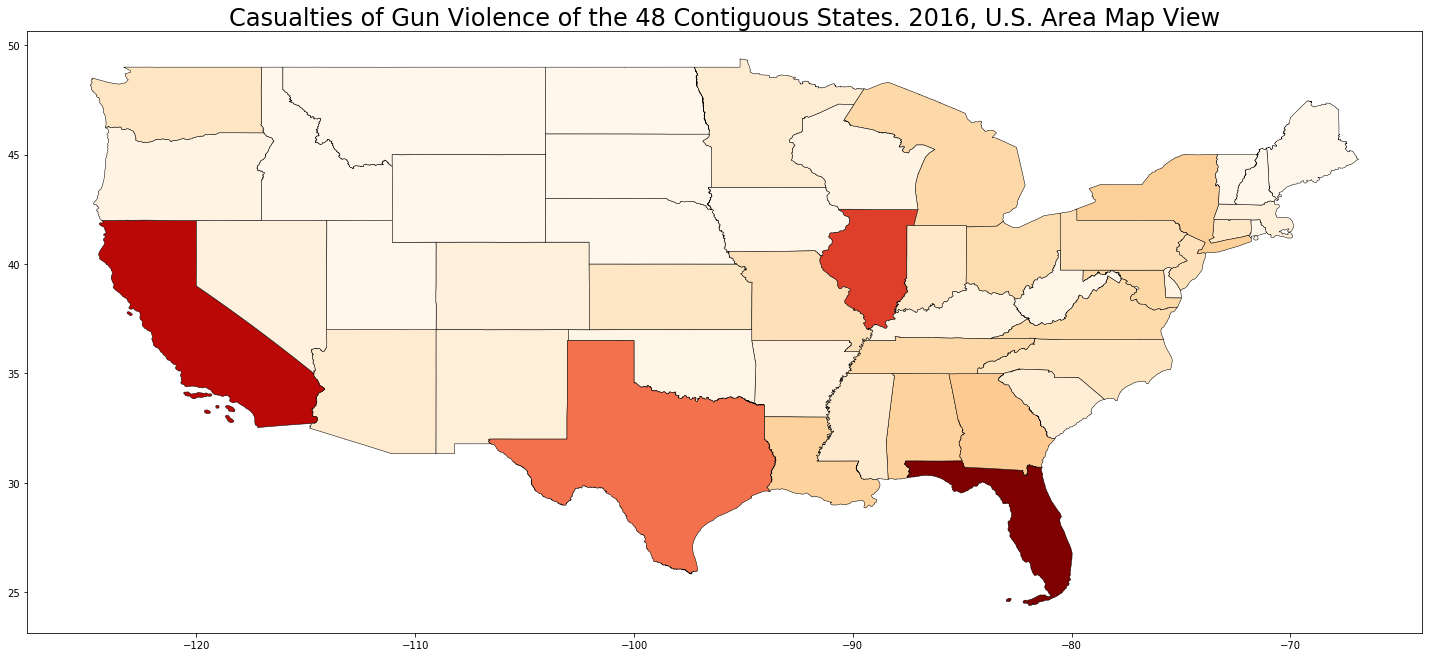

In [402]:
usa.drop(['Hawaii','Alaska','District of Columbia']).plot(column = 'Total Casualty', cmap = 'OrRd', figsize = (25,15), linewidth = 0.5, edgecolor = 'k')
plt.title("Casualties of Gun Violence of the 48 Contiguous States. 2016, U.S. Area Map View", fontsize = 24)

Text(0.5, 1.0, 'Casualties of Gun Violence of the 48 Contiguous States')

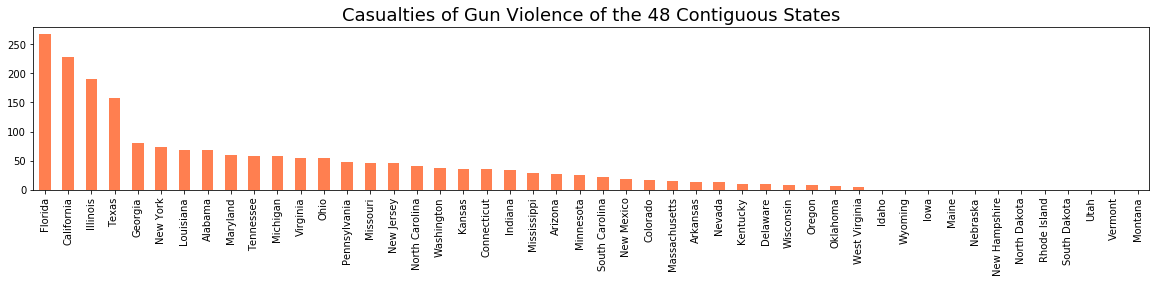

In [403]:
usa.drop(['Hawaii','Alaska','District of Columbia'])['Total Casualty'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,3), color = 'Coral')
plt.title("Casualties of Gun Violence of the 48 Contiguous States", fontsize = 18)

Florida is the top state with gun violence casualty

<a id = 'Total Casualties of Gun Violence in 2016 per Population'></a>
## Total Casualties of Gun Violence in 2016 per Population

In [404]:
usa['Total Casualty Per Population'] = usa['Total Casualty']/usa['Population']*1000000

Text(0.5, 1.0, 'Casualties of Gun Violence Per Million Population of the 48 Contiguous States. 2016, U.S. Area Map View')

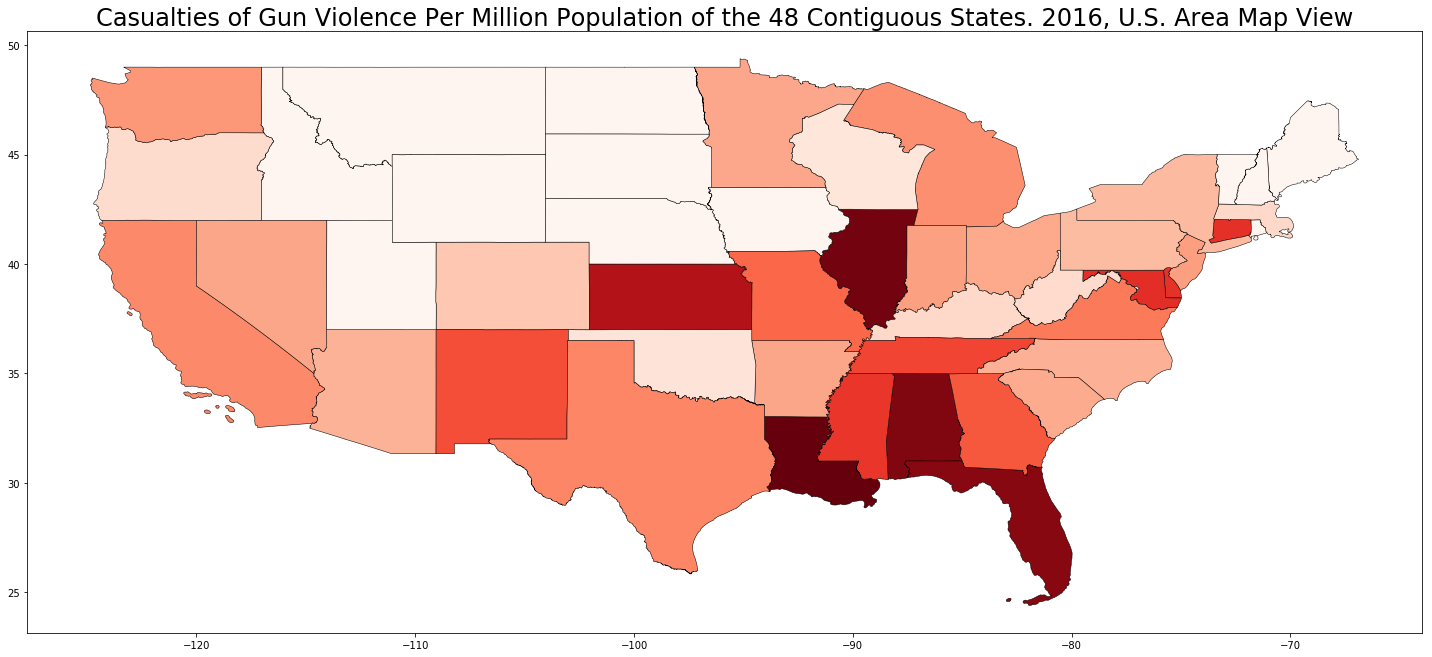

In [405]:
usa.drop(['Hawaii','Alaska','District of Columbia']).plot(column = 'Total Casualty Per Population', cmap = 'Reds', figsize = (25,15), linewidth = 0.5, edgecolor = 'k')
plt.title("Casualties of Gun Violence Per Million Population of the 48 Contiguous States. 2016, U.S. Area Map View", fontsize = 24)

Text(0.5, 1.0, 'Casualties of Gun Violence Per Million Population of the 48 Contiguous States')

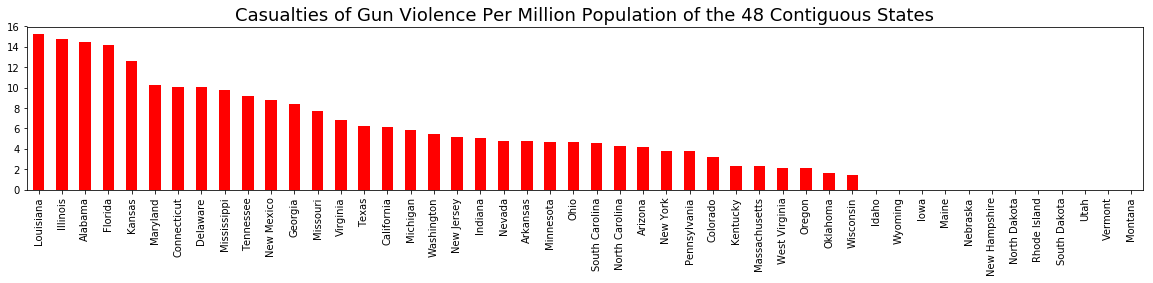

In [406]:
usa.drop(['Hawaii','Alaska','District of Columbia'])['Total Casualty Per Population'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,3), color = 'Red')
plt.title("Casualties of Gun Violence Per Million Population of the 48 Contiguous States", fontsize = 18)

Louisiana becomes the top state regarding the gun violence casualty after we normalized the data with population level of each state.

<a id = 'Complete Comparison for Census Data Criteria and Per Capita Casualties of Gun Violence'></a>
## Complete Comparison for Census Data Criteria and Per Capita Casualties of Gun Violence

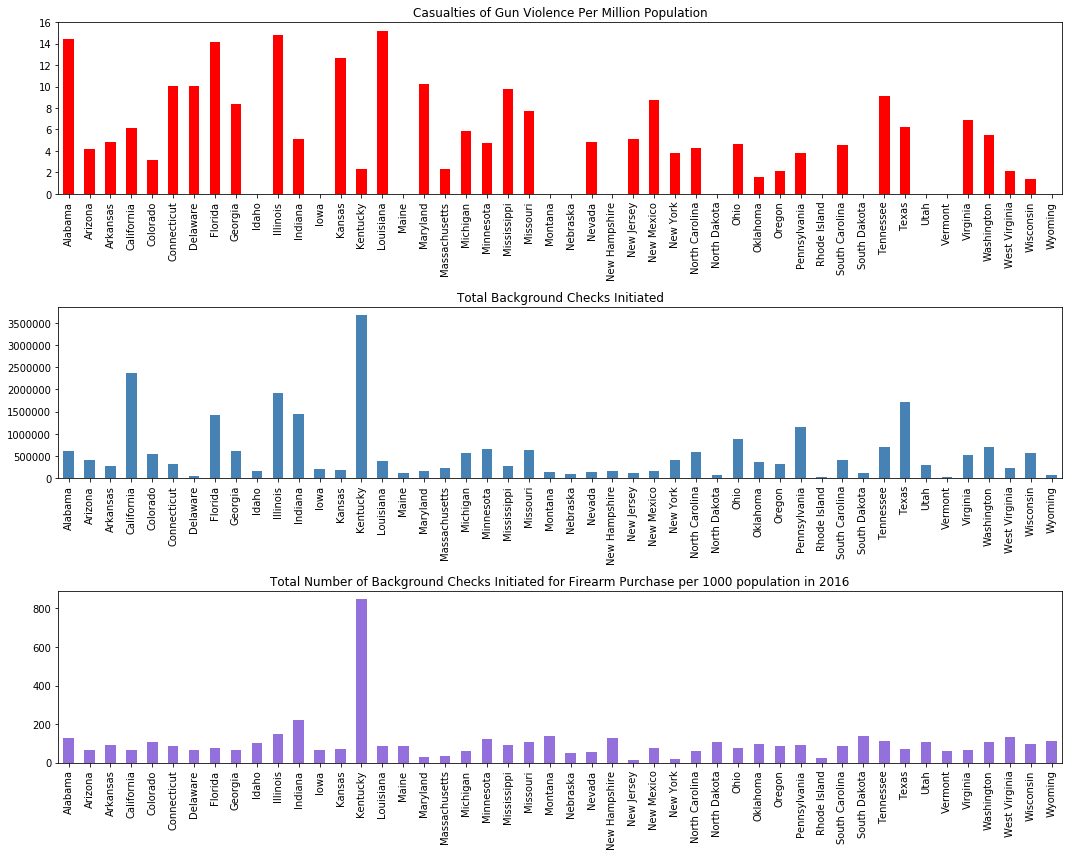

In [412]:
fig,ax = plt.subplots(3,1)
ax[0].set_title('Casualties of Gun Violence Per Million Population')
usa.drop(['Hawaii','Alaska','District of Columbia'])['Total Casualty Per Population'].plot(ax = ax[0], kind = 'bar', figsize = (15,12), color = 'Red')
ax[1].set_title('Total Background Checks Initiated')
usa.drop(['Hawaii','Alaska','District of Columbia'])['Total Background Checks Initiated'].plot(ax = ax[1], kind = 'bar', figsize = (15,12), color = 'steelblue')
ax[2].set_title('Total Number of Background Checks Initiated for Firearm Purchase per 1000 population in 2016')
usa.drop(['Hawaii','Alaska','District of Columbia'])['Gun Permits per person'].plot(ax = ax[2], kind = 'bar', figsize = (15,12), color = 'mediumpurple')
plt.tight_layout()

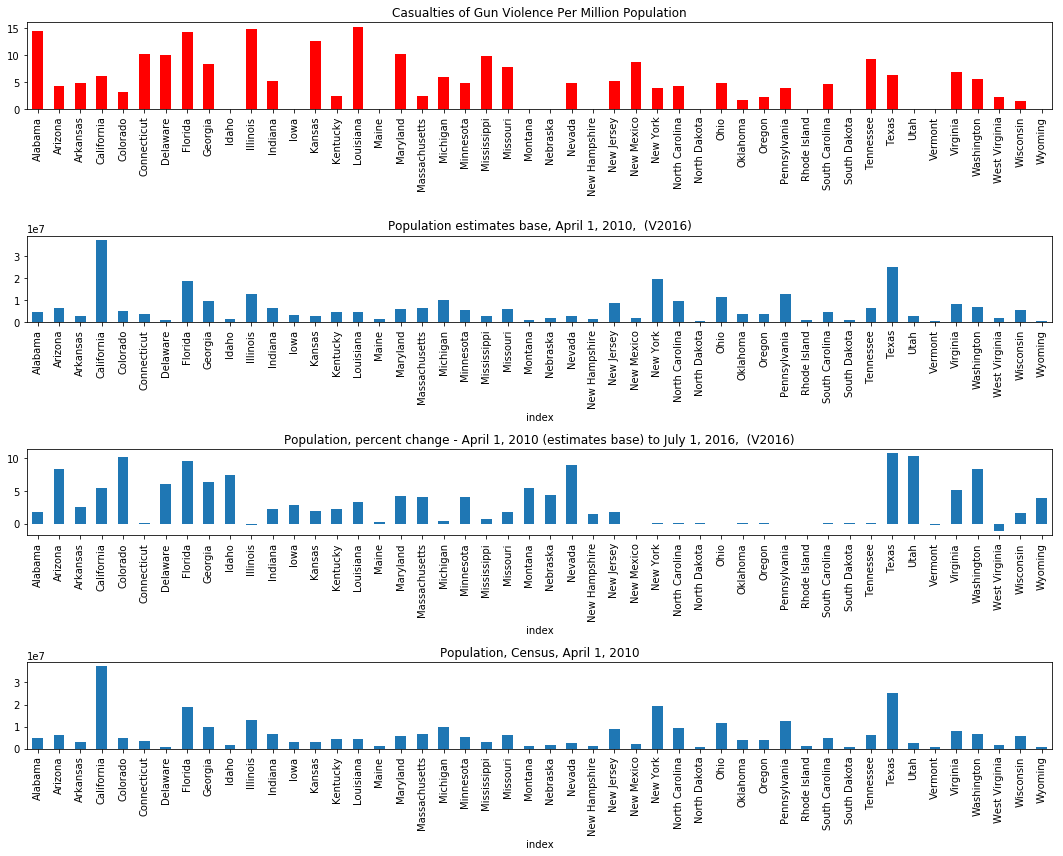

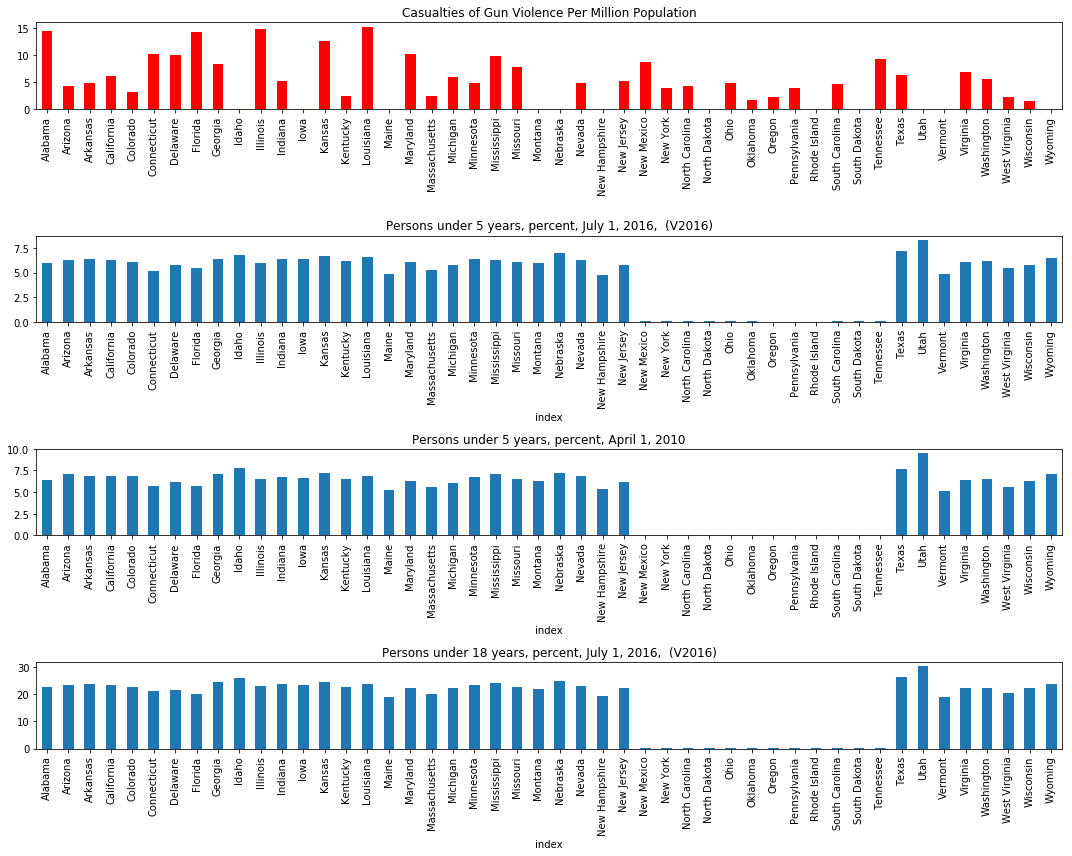

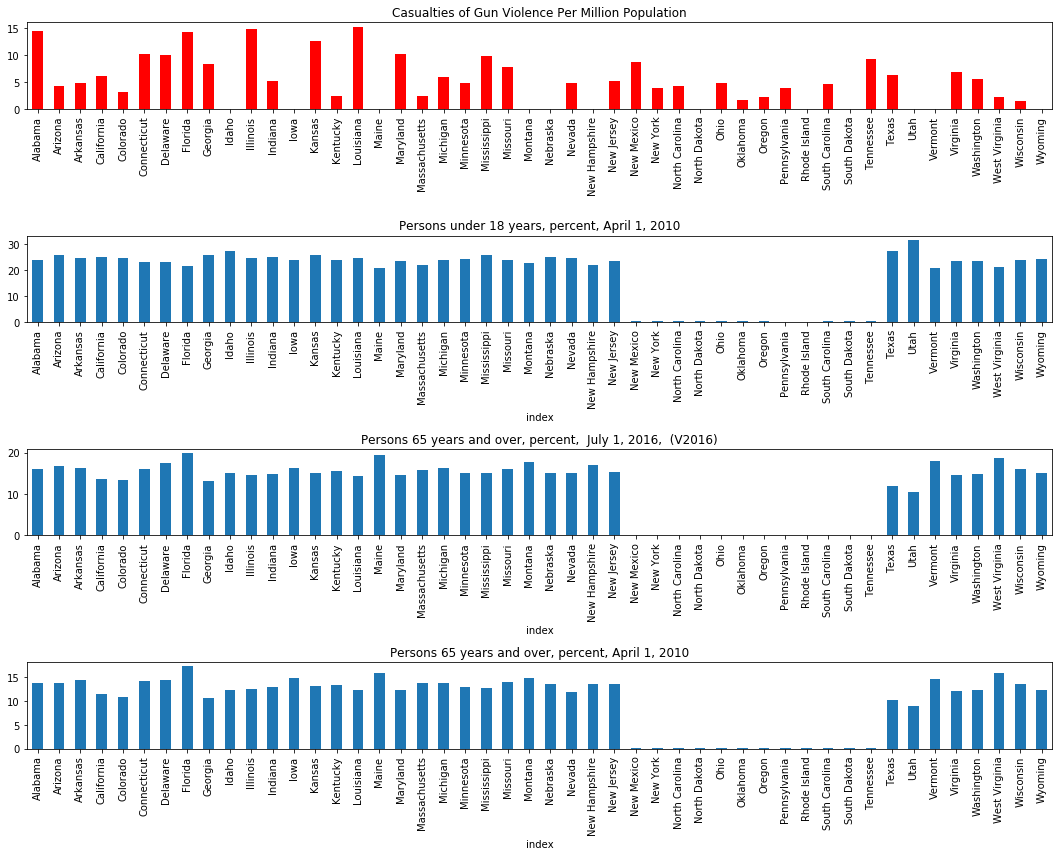

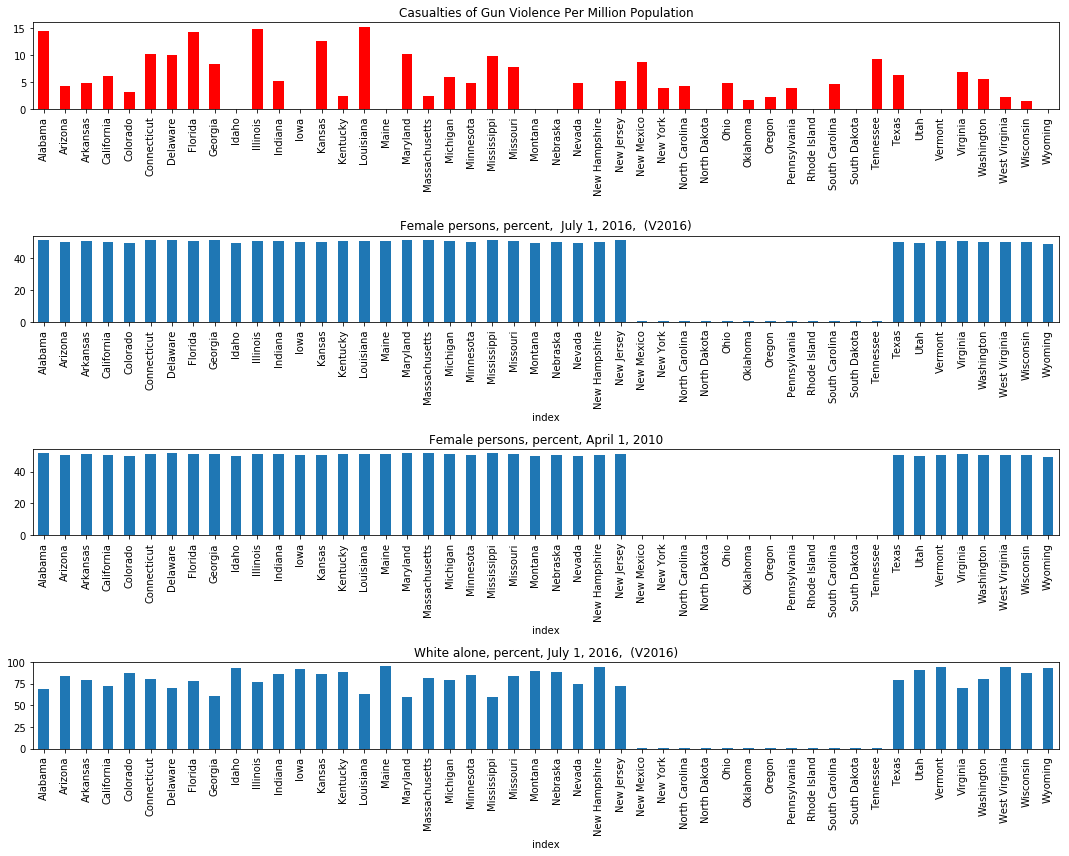

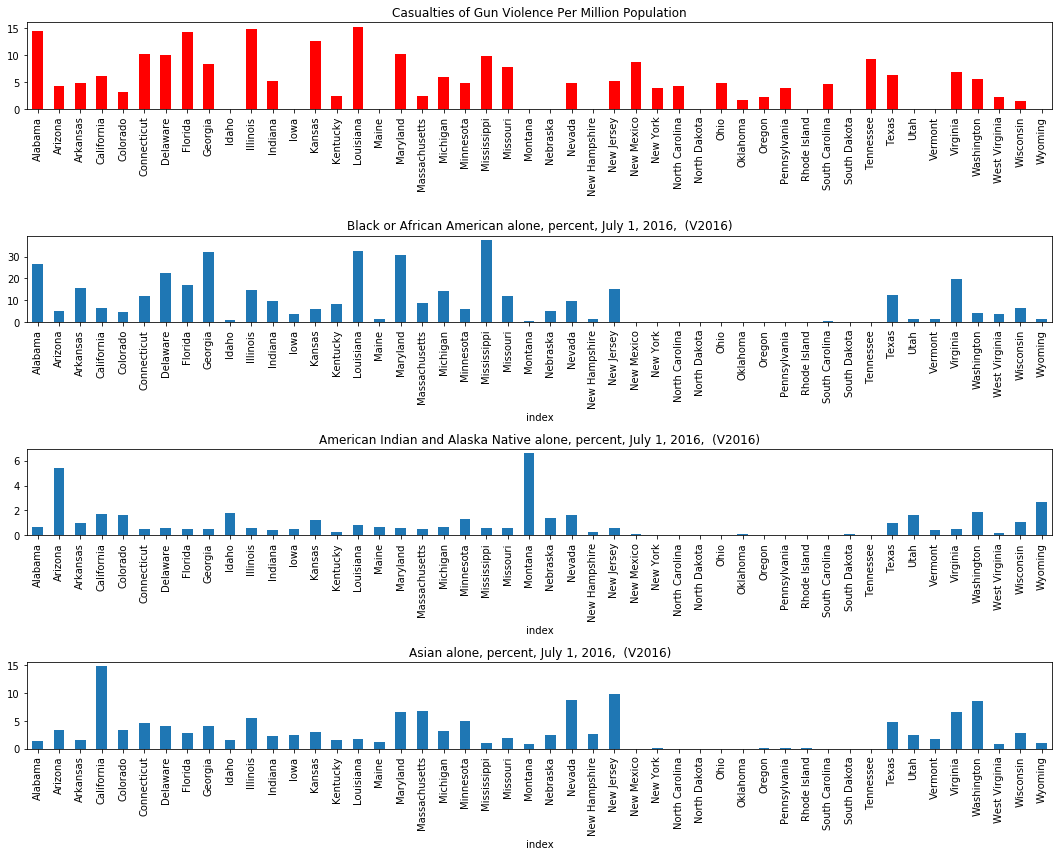

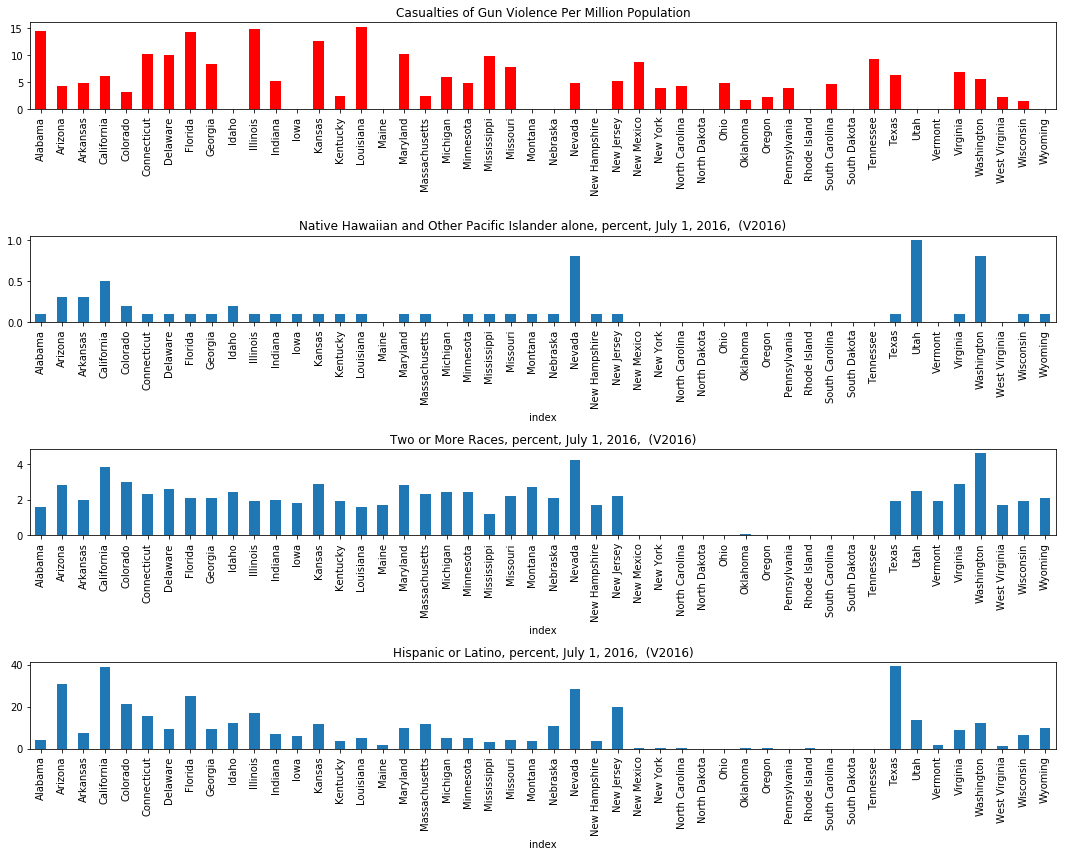

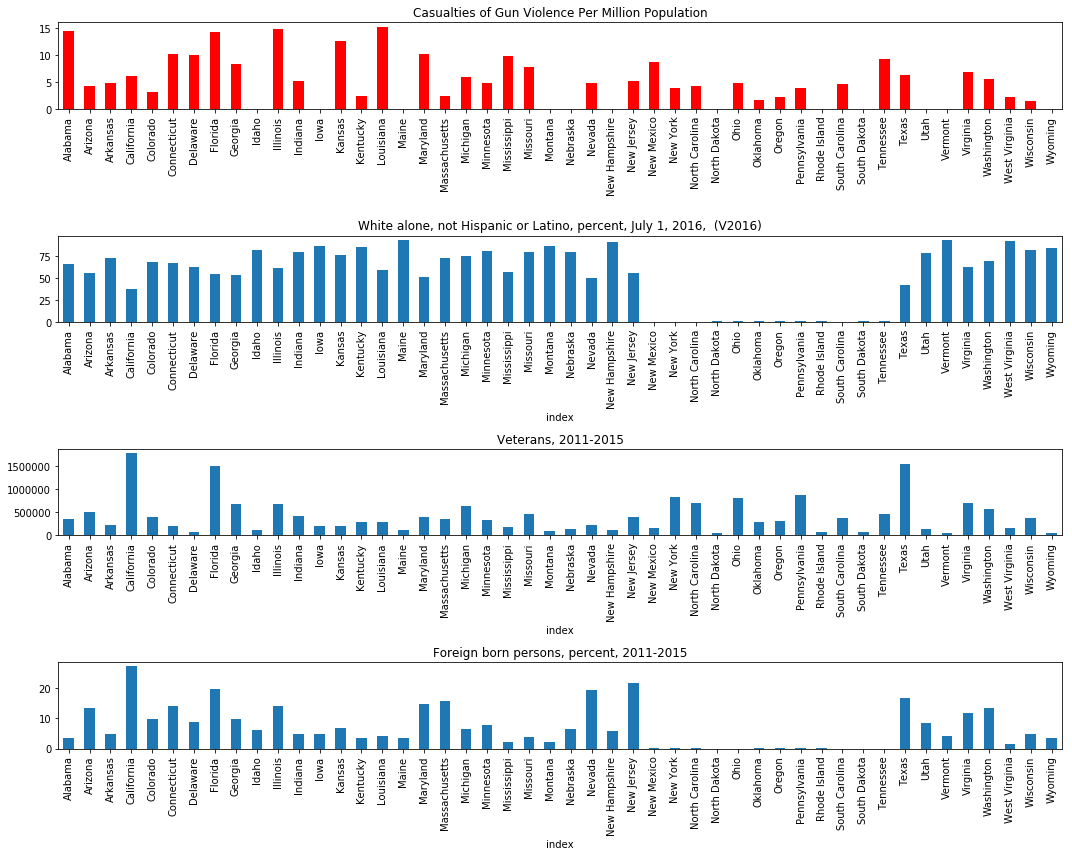

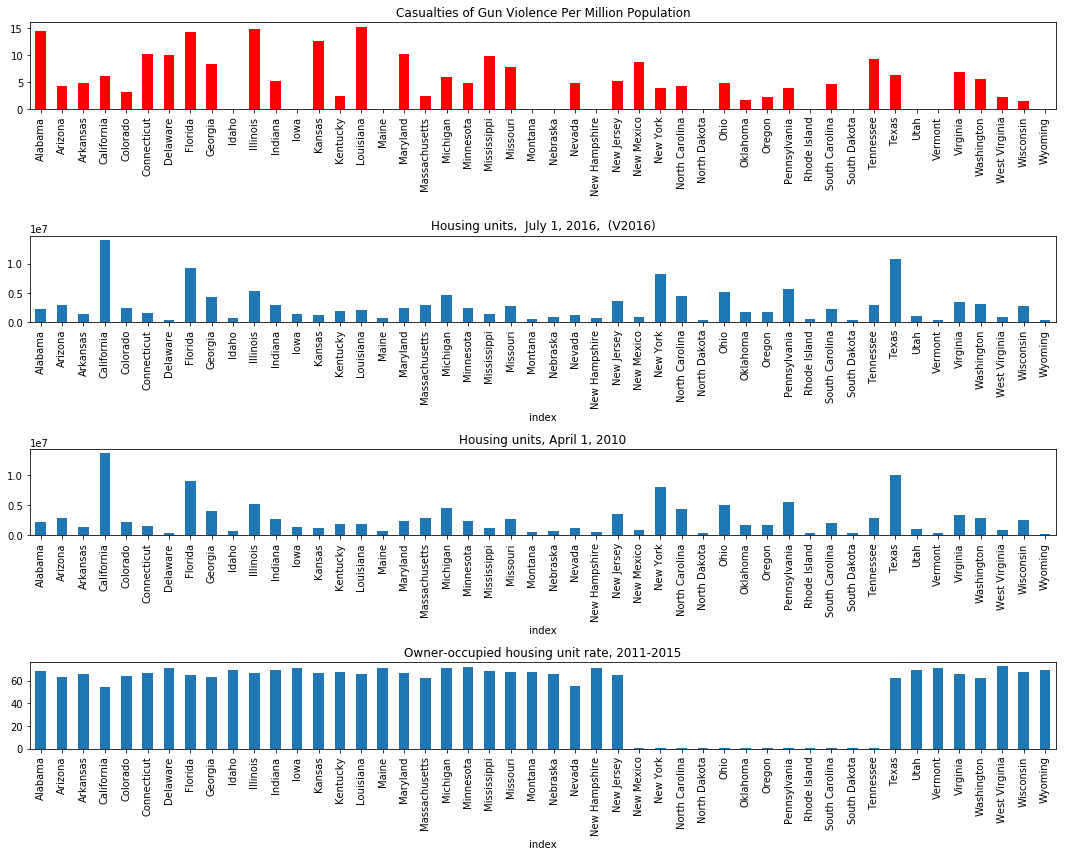

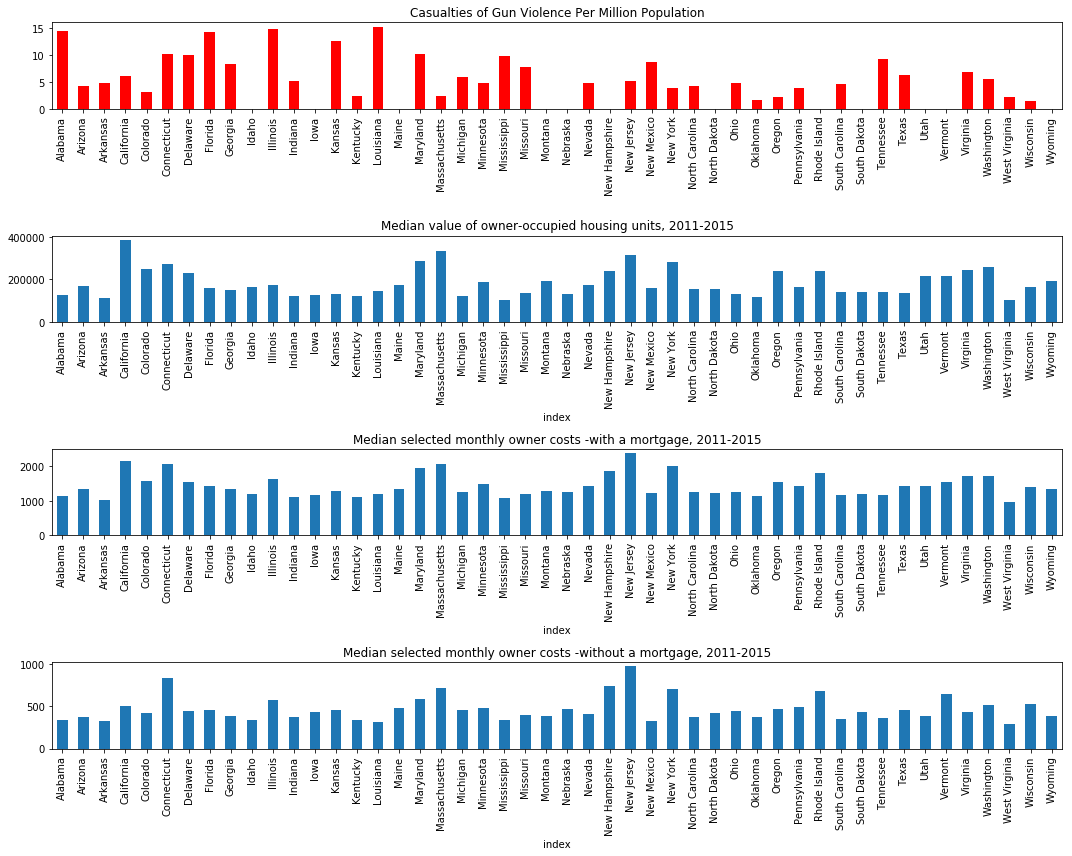

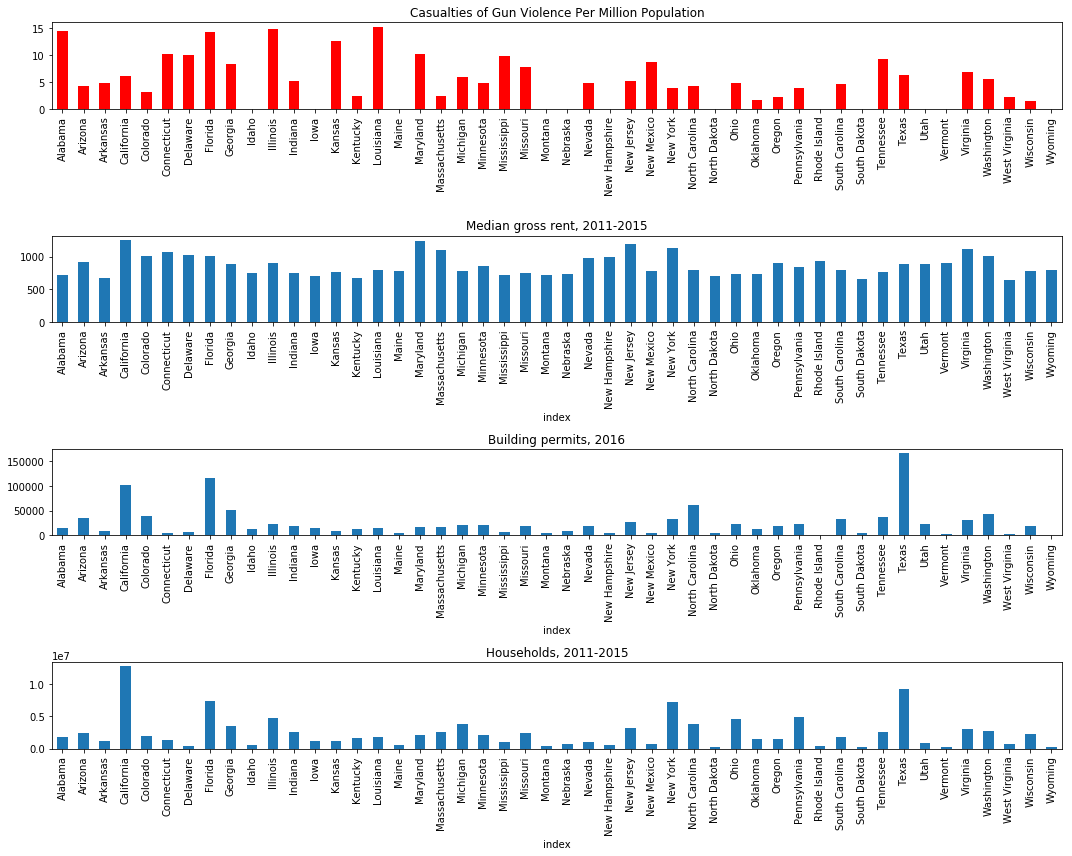

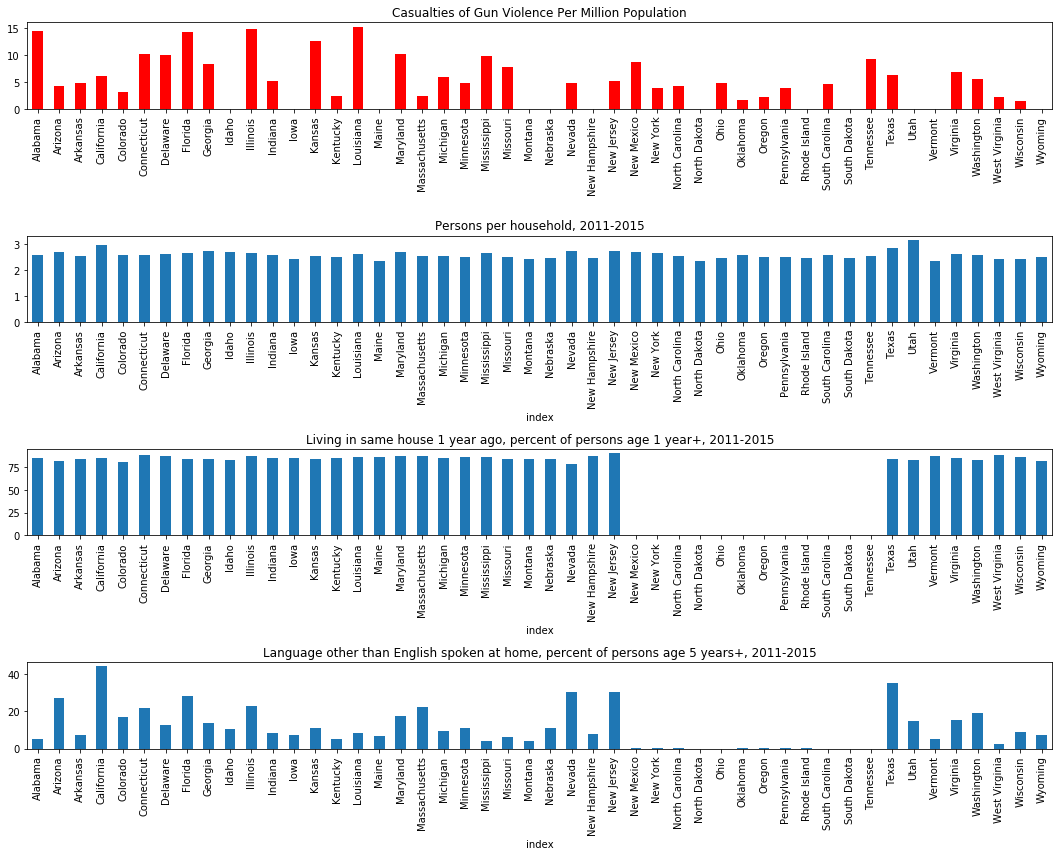

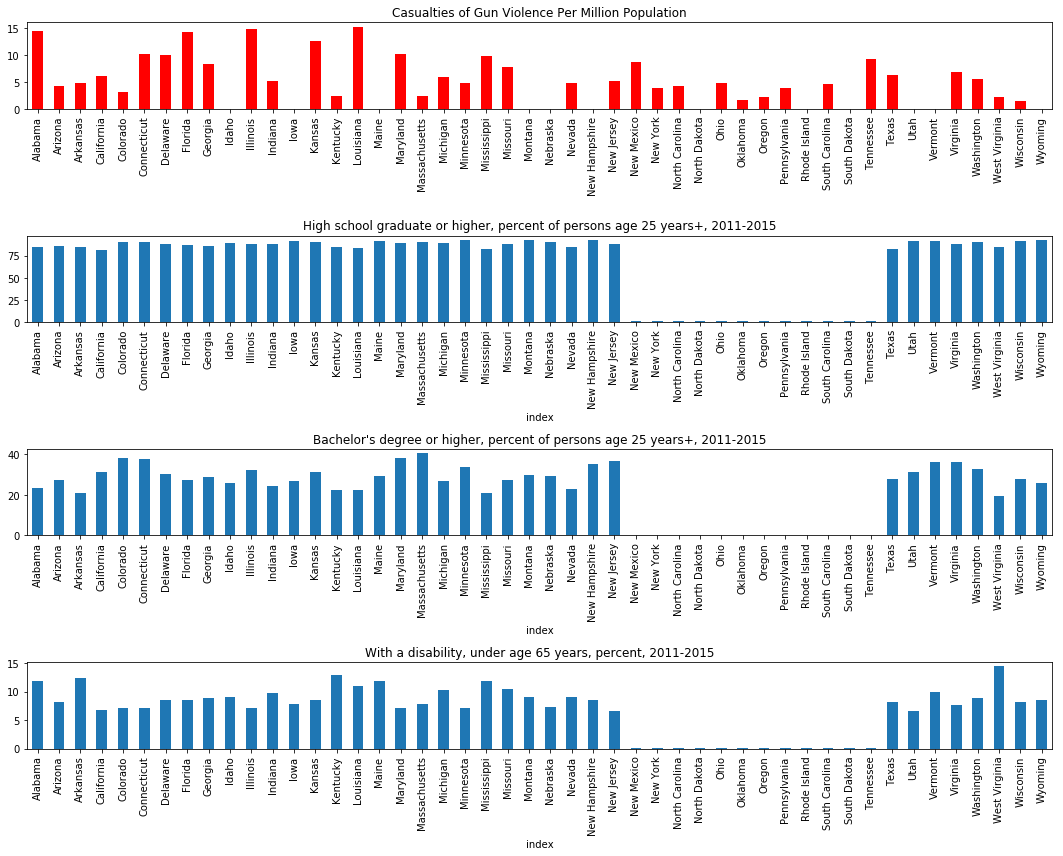

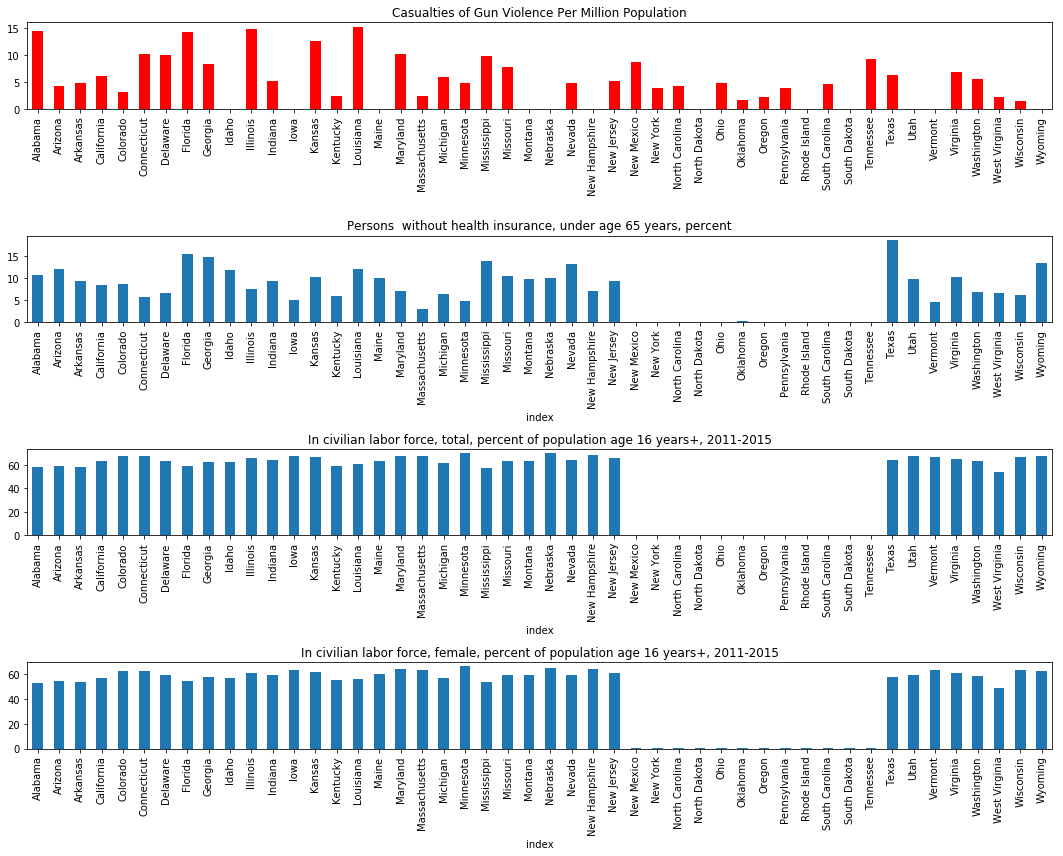

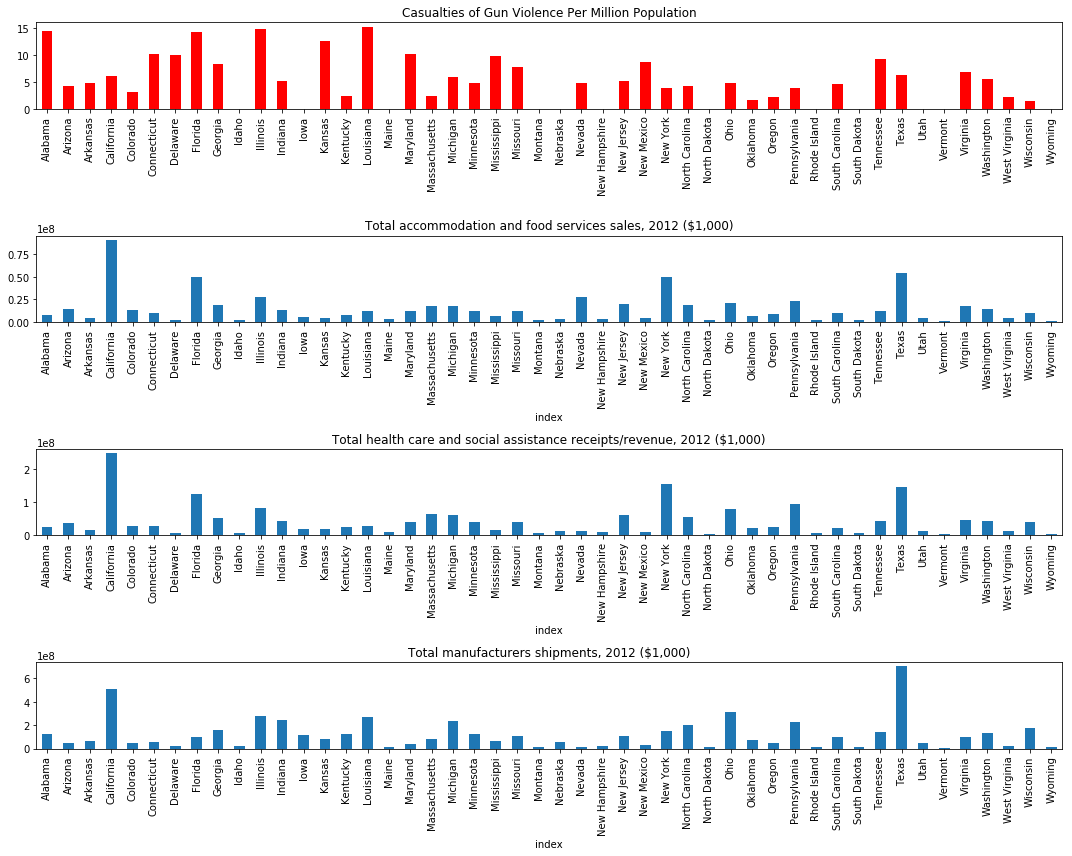

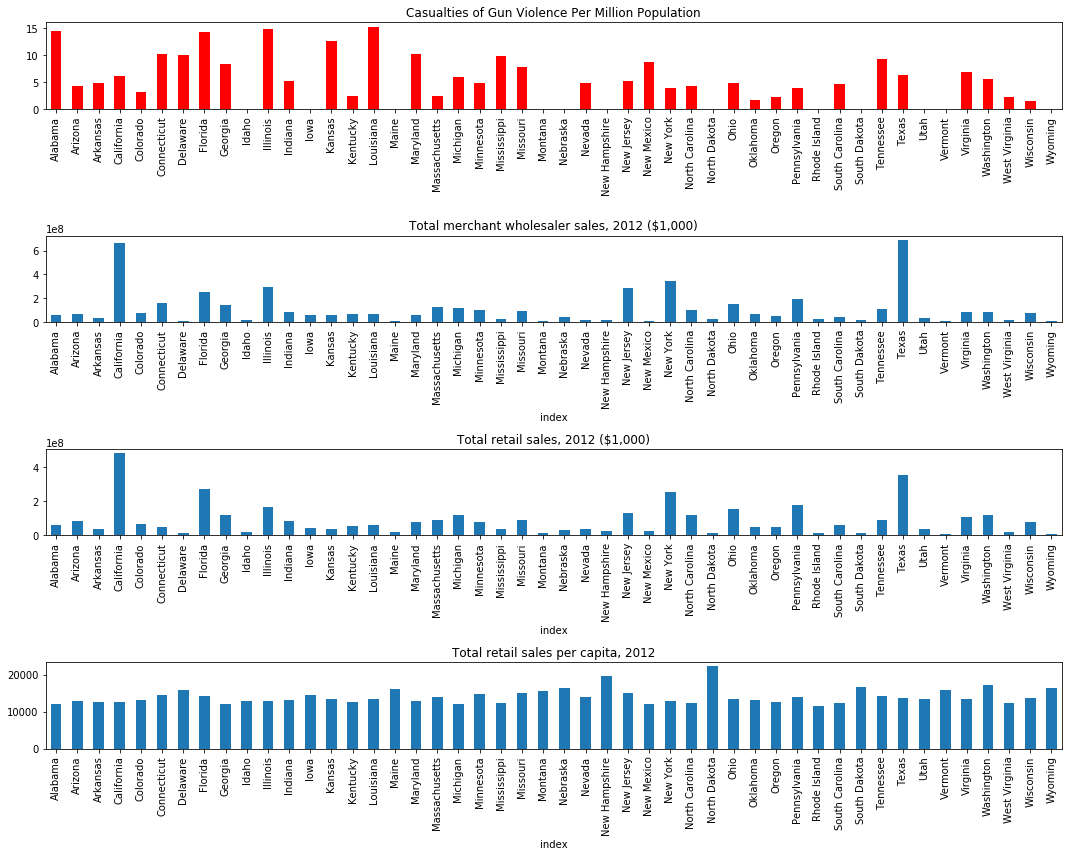

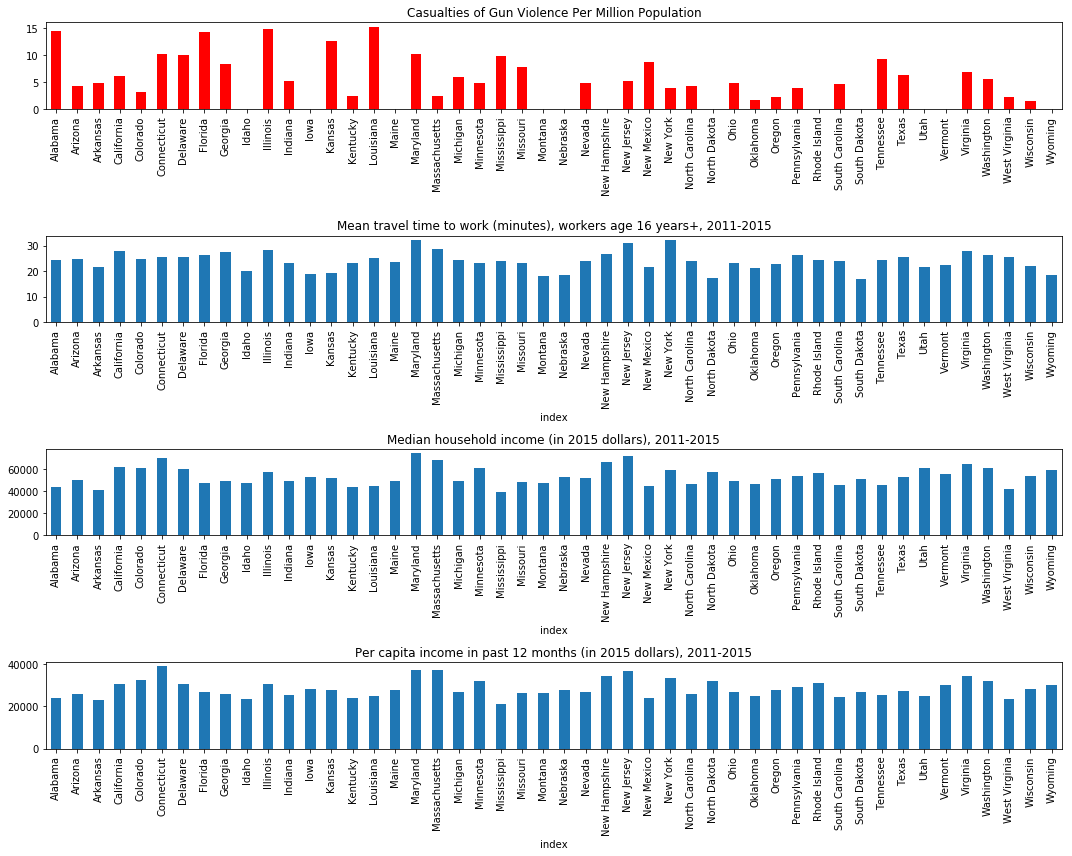

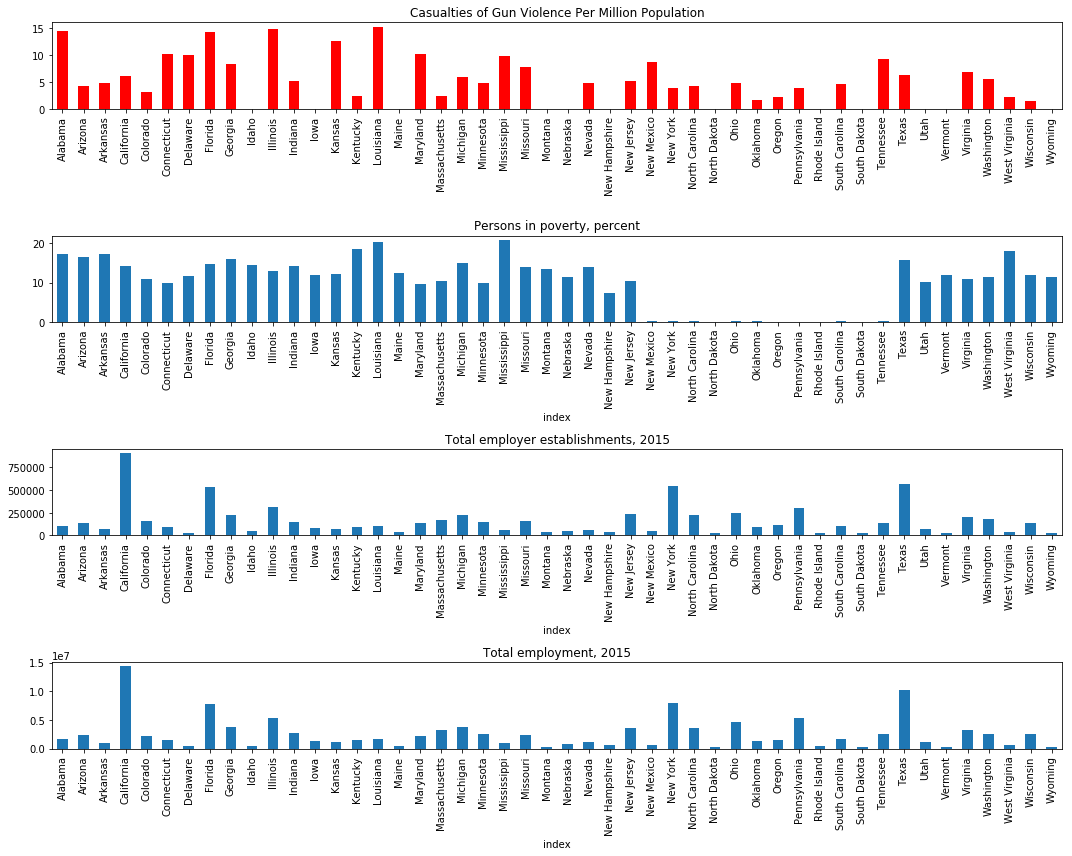

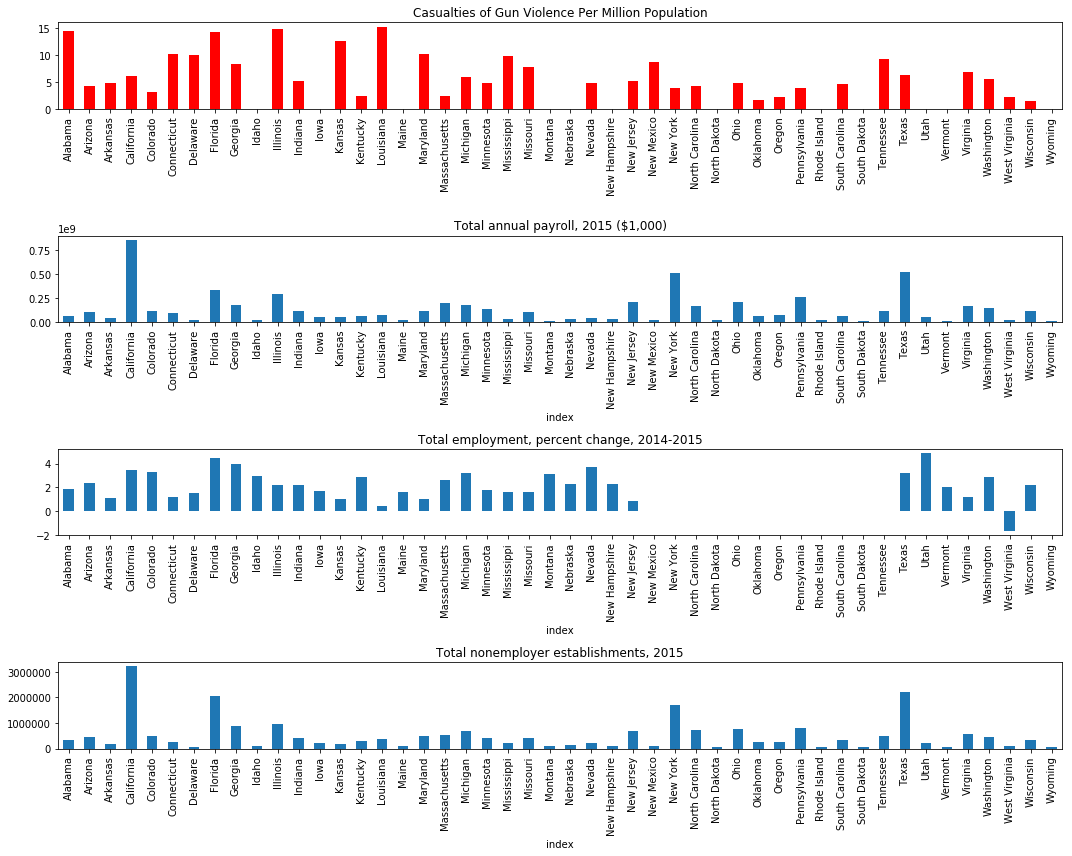

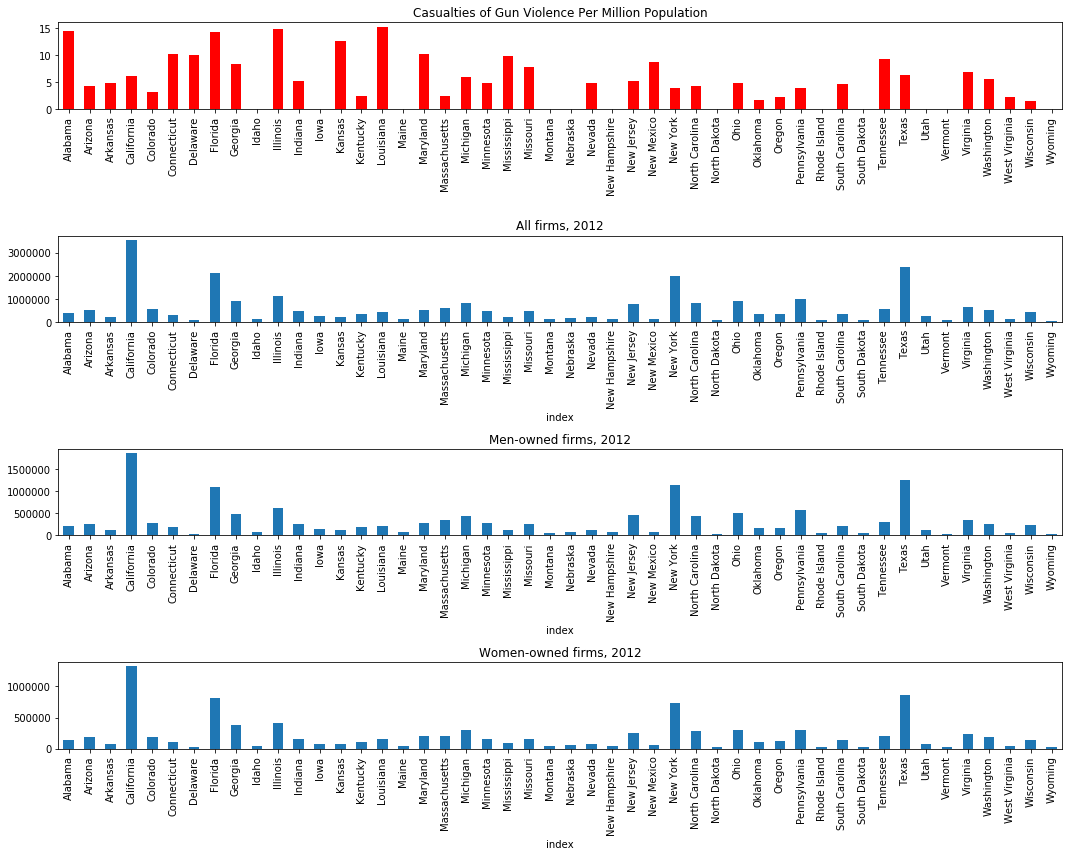

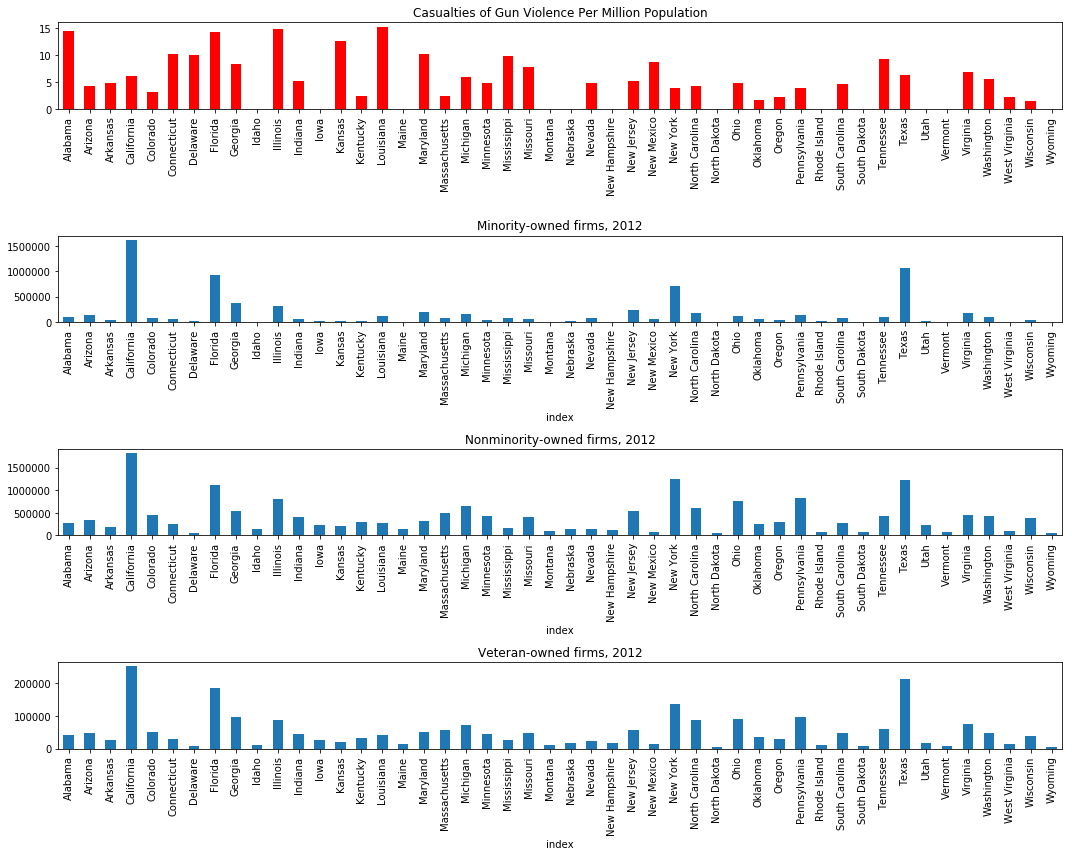

In [376]:
for i in range(0,60,3):
    fig,ax = plt.subplots(4,1)
    ax[0].set_title('Casualties of Gun Violence Per Million Population')
    usa.drop(['Hawaii','Alaska','District of Columbia'])['Total Casualty Per Population'].plot(ax = ax[0], kind = 'bar', figsize = (20,3), color = 'Red')
    for k in range(1,4):
        test = us_census_data.loc[k + i]
        test.drop('Fact').reset_index().set_index('index').drop(['Hawaii','Alaska'])[k+i].plot(ax = ax[k], kind = 'bar', figsize = (15,12))
        ax[k].set_title(test['Fact'])
    plt.tight_layout()
